# Installing Required Libs

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet tokenizers
!pip install --quiet sentencepiece

# Importing the Libs

In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Checking the availability of GPU

In [3]:
import torch

# Check if a GPU is available and its name
if torch.cuda.is_available():
    print("CUDA is available. GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using:", torch.device("cpu"))


CUDA is not available. Using: cpu


# Data Pre-Processing

In [1]:
ls

Reddit_Data.csv
Twitter_Data.csv
new_df.csv
predicting-tweets-sentiment-by-huggingface-bert.ipynb


In [7]:
df = pd.read_csv('Twitter_Data.csv')

In [9]:
df.head(10)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
5,kiya tho refresh maarkefir comment karo,0.0
6,surat women perform yagna seeks divine grace f...,0.0
7,this comes from cabinet which has scholars lik...,0.0
8,with upcoming election india saga going import...,1.0
9,gandhi was gay does modi,1.0


In [11]:
df.tail(10)

,clean_text,category
162970,raga knows dat wont spared modi courts for his...,1.0
162971,congress veteran sudhakar reddy joins bjp afte...,0.0
162972,engine growth modi unveils indias first 12000 ...,1.0
162973,modi promised 2014 lok sabha elections that be...,1.0
162974,save your agenda peddling ’ had with terror at...,0.0
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0
162979,have you ever listen about like gurukul where ...,1.0


### Removing the NULL Values

In [13]:
df[df['clean_text'].isnull()].index

Index([148, 158694, 159443, 160560], dtype='int64')

In [15]:
df[df['category'].isnull()].index

Index([130448, 155642, 155698, 155770, 158693, 159442, 160559], dtype='int64')

In [17]:
df = df.drop([148, 158694, 159443, 160560,130448, 155642, 155698, 155770, 158693, 159442, 160559])
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [20]:
df[df['clean_text'].isnull()].index

Index([], dtype='int64')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


### Ploting the Category Graph

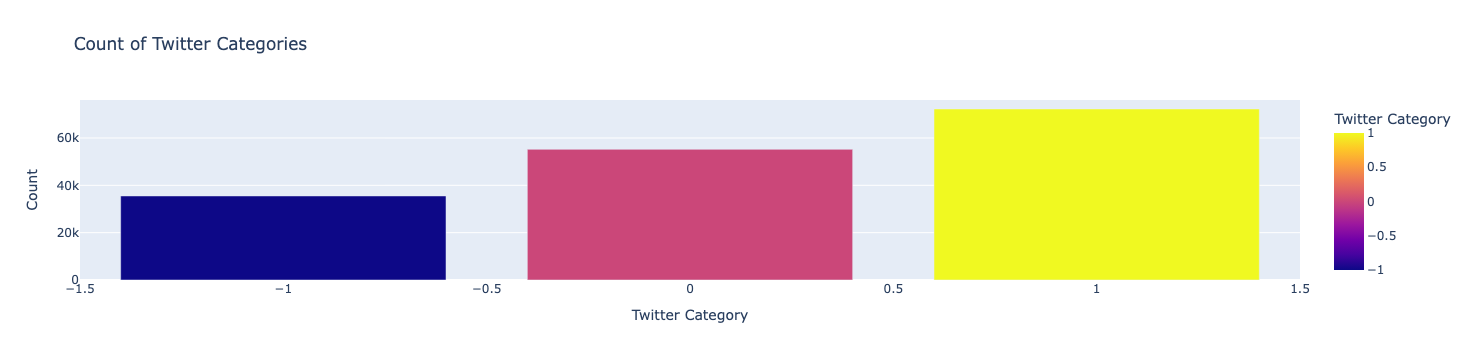

In [38]:
import plotly.express as px

category_counts = df['category'].value_counts().reset_index()

category_counts.columns = ['Twitter Category', 'Count']

fig = px.bar(category_counts, 
             x='Twitter Category', 
             y='Count', 
             labels={'Twitter Category': 'Twitter Category', 'Count': 'Count'},
             title='Count of Twitter Categories',
             color='Twitter Category',
             color_discrete_sequence=["#01BEFE", "#FFDD00", "#FF7D00"])

fig.show()

### Asigning values from Category to Sentiment 
* -1 = 0
* 0 = 1
* +1 = 2

In [40]:
def to_sentiment(rating):
  rating = int(rating)
  if rating == -1:
    return 0
  elif rating == 0 :
    return 1
  else:
    return 2

In [42]:
df['sentiment'] = df.category.apply(to_sentiment)

In [44]:
df.category.value_counts() 

category
 1.0    72249
 0.0    55211
-1.0    35509
Name: count, dtype: int64

In [54]:
print(df)

                                                       clean_text  category  \
category                                                                      
-1.0     0      desperately waiting watch the not movie review...      -1.0   
         1      madam kanpur and akbarpur seat will loose cand...      -1.0   
         2      everything that happened under nehru gandhi du...      -1.0   
         3      funny that such renowned writer doesnt know th...      -1.0   
         4      and all this possible only due the efforts inv...      -1.0   
...                                                           ...       ...   
 1.0     35504  modi please now focus water saving which very ...       1.0   
         35505  your inclination for modi can beat sati savitr...       1.0   
         35506  yeah hope they see that modi not god practice ...       1.0   
         35507  says congress will give special status comes p...       1.0   
         35508  congratulation drdo and isro for suc

### Normalizing the Entries 

In [59]:
g = df.groupby('category')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

ValueError: 'category' is both an index level and a column label, which is ambiguous.

In [56]:
# Save the DataFrame to a CSV file
df.to_csv('new_df.csv', index=False)

In [61]:
df.category.value_counts() 

category
-1.0    35509
 0.0    35509
 1.0    35509
Name: count, dtype: int64

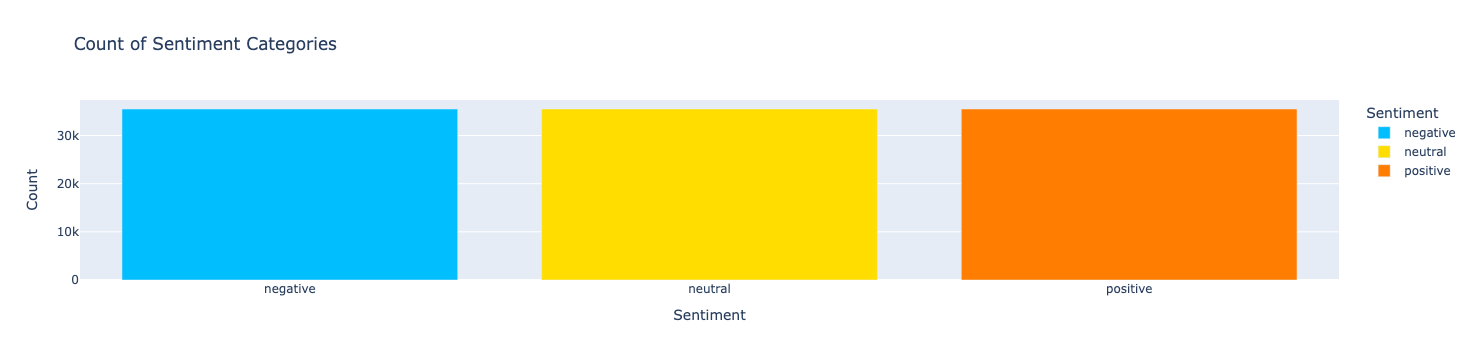

In [73]:
import plotly.express as px

df['sentiment'] = df['sentiment'].astype('category')

category_counts = df['sentiment'].value_counts().reset_index()

category_counts.columns = ['Sentiment', 'Count']

class_names = ['negative', 'neutral', 'positive']

category_counts['Sentiment'] = category_counts['Sentiment'].map(dict(enumerate(class_names)))

# Create the Plotly bar chart
fig = px.bar(category_counts, 
             x='Sentiment', 
             y='Count', 
             labels={'Sentiment': 'Sentiment', 'Count': 'Count'},
             title='Count of Sentiment Categories',
             color='Sentiment',
             color_discrete_sequence=["#01BEFE", "#FFDD00", "#FF7D00"])

# Display the plot
fig.show()

### Shuffling Data

In [75]:
df = df.sample(frac=1)
df

clean_text  category  \
category                                                                      
-1.0     7255   why the above mentioned achievements the previ...      -1.0   
 0.0     21951  hoping that all the questions related for indi...       0.0   
         29217  already you have been used ace garner morality...       0.0   
 1.0     30856  both are wrong but there huge difference betwe...       1.0   
 0.0     9995   difference between mallya nirav modi case nira...       0.0   
...                                                           ...       ...   
         21861           namo merchandise owaisi brothers attack        0.0   
         26019  inspite repeated warnings from election commis...       0.0   
-1.0     2200   india’ narendra modi projects military might t...      -1.0   
 0.0     33628  what was the need for modi the time election v...       0.0   
-1.0     6447   unfortunate incidence which now affects our co...      -1.0   

               sentiment  
category                  
-1.0     7255          0  
 0.0     21951         1  
         29217         1  
 1.0     30856         2  
 0.0     9995          1  
...                  ...  
         21861         1  
         26019         1  
-1.0     2200          0  
 0.0     33628         1  
-1.0     6447          0  

[106527 rows x 3 columns]

# Model Creation

In [88]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [90]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [92]:
MAX_LEN= 280
BATCH_SIZE = 32

In [98]:
class TwitterSentimentDataset(Dataset):
  def __init__(self, tweets, targets, tokenizer, max_len):
      self.tweets = tweets
      self.targets = targets
      self.tokenizer = tokenizer
      self.max_len = max_len

  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweets = str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      tweets,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
  
    return {
      'tweet_text': tweets,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [100]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [102]:
df_train.shape, df_test.shape, df_test.shape

((95874, 3), (5327, 3), (5327, 3))

In [104]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TwitterSentimentDataset(
    tweets=df.clean_text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )	
  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [106]:
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

In [108]:
'''data = next(iter(train_data_loader))
data.keys()'''

'data = next(iter(train_data_loader))\ndata.keys()'

In [110]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [112]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)
  def forward(self, input_ids, attention_mask):
    output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    ) 
    pooled_output = output[1]
    output = self.drop(pooled_output)
    return self.out(output)
    return self.softmax(output)

In [114]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [116]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/opt/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [118]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    optimizer.zero_grad()
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    loss = loss_fn(outputs, targets)
    _, preds = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
   
  return correct_predictions.double() / n_examples, np.mean(losses)

In [120]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    with torch.no_grad():
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [122]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    best_accuracy = val_acc


Epoch 1/5
----------


KeyboardInterrupt: 